# Lab 2 - uncertainty in neural networks

# Plan for today


1. Learn about **Expected Calibration Error**
    * measure it for an example neural network
    * minimize it for that network
2. See it's usages in practice:
    * out-of-distribution detection
    * early exit networks
    


**Question 1** - can you think of a real-life example where knowing the prediction uncertainty is important?

**YOUR ANSWER HERE**

In [87]:
from torch.optim import SGD
from torch import nn
import torch
from typing import List
from torchvision.datasets import FashionMNIST, CIFAR10
from torchvision import transforms as tv
from torch.utils.data import DataLoader, Subset
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from torchvision.models import vgg16, vgg16_bn, resnet50

In [88]:
device = torch.device( "cpu")
device

device(type='cpu')

Today, we will work with the [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset, with a small twist.

In [89]:
trans = transform=tv.Compose([tv.ToTensor(), tv.Normalize(mean=[0.5, 0.5, 0.5], std=[1,1,1])])
ds = CIFAR10('./data', train=True, target_transform=None, download=True, transform=trans)# transform the data from PIL image to a tensor
ds_test = CIFAR10('./data', train=False, target_transform=None, download=True, transform=trans) # transform the data from PIL image to a tensor

Files already downloaded and verified
Files already downloaded and verified


We will split the data in half, to simulate two data distributions:

In [90]:
# INCLUDED_CLASSES = [0, 2, 4, 6, 8]

ds_train_included = Subset(ds, indices = [i for (i, c) in enumerate(ds.targets) if c %2 == 0 ])
ds_train_excluded = Subset(ds, indices = [i for (i, c) in enumerate(ds.targets) if c %2 != 0])

ds_test_included = Subset(ds_test, indices = [i for (i, c) in enumerate(ds_test.targets) if c %2 == 0 ])
ds_test_excluded = Subset(ds_test, indices = [i for (i, c) in enumerate(ds_test.targets) if c %2 != 0 ])

batch_size=128

dl_train_in = DataLoader(ds_train_included, batch_size, shuffle=True)
dl_train_ex = DataLoader(ds_train_excluded, batch_size, shuffle=True)

dl_test_in = DataLoader(ds_test_included, batch_size, shuffle=False)
dl_test_ex = DataLoader(ds_test_excluded, batch_size, shuffle=False)

In [91]:
dl_train = DataLoader(ds,batch_size,shuffle = True)
dl_test = DataLoader(ds_test,batch_size,shuffle = False)

## 1 - Expected calibration error


A perfectly calibrated model will have the following property: **A prediction with score $p$ means that there is a $p$ chance, that the model is right**.


Expected Calibration Error (ECE) is a way to measure how well a model estimates **it's own uncertainty**, i.e. how well it is calibrated:

To calculate it, we need to:
* make predictions with our model
* divide the predictions into bins $B_m$ based on their score (confidence)
* calculate the accuracy of predictions in each $B_m$
* measure the difference between the confidence of each bin and it's mean accuracy

Formally:

$$
ECE = \sum_{i=1}^M \frac{|B_m|}{N} \left| acc(B_m) - conf(B_m) \right|.
$$

A useful way to visualize the model calibration is to plot a histogram of prediction scores and a reliability diagram, e.g:

![reliability](https://drive.google.com/uc?id=1K1VdWAX1HU5xXbQ-Ya3TTcoGTfjuPM9C)




Unfortunately, models trained with softmax are not guaranteed to be well-calibrated. 

### Task for you - calculate ECE and draw a reliability diagram

Below, there is a basic neural network definition with configurable depth and an example training loop.

Please train this network on CIFAR-10. Afterwards, run predictions on a validation dataset, calculate the ECE and visualize the predictions histogram and the reliabilility diagram (you should produce figures similar to the ones above).

You can repeat this for three different network setups by introducing various modifications, e.g.

* changing network depth / hidden sizes (the easiest, should be enough to notice something)
* adding batchnorm to the network
* adding $l2$ regularization

Please calculate the ECE and produce visualizations for all three networks. Then, briefly summarize what you did and how it influenced the calibration.

In [92]:
class Net(nn.Module):
  def __init__(self, hidden_sizes: List[int], downsize_steps: List[int], in_hw: int = 32, n_classes: int = 10, batch_norm: bool = False):
    """
    Args:
      hidden sizes - hidden size of each consecutive convolution
      downsize_steps - numbers of convolutions for which there will be stride = 2
      in_hw - size of the input image
      n_classes - number of output classes
    """
    super().__init__()
    self.batch_norm = batch_norm
    assert len(hidden_sizes) >= 1
    
    self.conv1 = nn.Conv2d(3, hidden_sizes[0], 3, padding=1)

    convs = []

    for i, hs in enumerate(hidden_sizes[:-1]):
      hs_next = hidden_sizes[i+1]
      stride = 2 if i+1 in downsize_steps else 1
      if(self.batch_norm):
        convs.append(
            nn.Sequential(
              nn.BatchNorm2d(hs),
              nn.ReLU(),
              nn.Conv2d(hs, hs_next, 3, padding=1, stride=stride),
          )
        )
      else:
        convs.append(
            nn.Sequential(
              nn.ReLU(),
              nn.Conv2d(hs, hs_next, 3, padding=1, stride=stride),
          )
        )
    self.convs = nn.Sequential(*convs)

    dhw = in_hw // (2 ** len(downsize_steps))

    out_dim = dhw * dhw * hidden_sizes[-1]
    if(self.batch_norm):
      self.out = nn.Sequential(
          nn.BatchNorm2d(hidden_sizes[-1]),
          nn.ReLU(),
          nn.Flatten(),
          nn.ReLU(),
          nn.Linear(out_dim, n_classes)
      )
    else:
      self.out = nn.Sequential(
          nn.ReLU(),
          nn.Flatten(),
          nn.ReLU(),
          nn.Linear(out_dim, n_classes)
      )

  def forward(self, x):
    if(self.batch_norm):
      m = nn.BatchNorm2d(3)
      x = m(x)
    x = self.conv1(x)
    for c in self.convs:
      x = c(x)
    return self.out(x)



In [93]:
def train_net(net, number_of_epochs: int = 20, lr: float = 0.001):
  net = net.to(device)
  loss_fn = nn.CrossEntropyLoss() 
  opt = torch.optim.Adam(net.parameters(), lr=lr) 

  epoch_progress = tqdm(list(range(number_of_epochs)))
  for i in epoch_progress:
      train_loss = 0
      y_train_predicted = []
      y_train_true = []
      net.train()
      for iteration, (X_train, y_train) in tqdm(enumerate(dl_train_in), f"Training epoch {i}", total=len(dl_train_in), leave=False):
          # notice we are training / testing on dl_train_in - the same distribution of data!
          X_train, y_train = [t.to(device) for t in [X_train, y_train]]
          opt.zero_grad()
          y_pred = net(X_train)
          loss = loss_fn(y_pred, y_train)
          loss.backward()
          opt.step()
          train_loss += loss.item()
          y_train_predicted.extend(y_pred.argmax(dim=1).cpu().numpy())
          y_train_true.extend(y_train.cpu().numpy())
          
          
      val_loss = 0
      y_predicted = []
      y_true = []

      net.eval()
      with torch.no_grad():
          for iteration, (X_val, y_val) in tqdm(enumerate(dl_test_in), f"Val epoch {i}",  total=len(dl_test_in), leave=False):
              X_val, y_val = [t.to(device) for t in [X_val, y_val]]

              y_pred = net(X_val)
              loss = loss_fn(y_pred, y_val)
              val_loss += loss.item()
              y_pred = y_pred.argmax(dim=1)
              y_true.extend(y_val.cpu().numpy())
              y_predicted.extend(y_pred.cpu().numpy())
      
      train_acc = accuracy_score(y_train_true, y_train_predicted)
      val_acc = accuracy_score(y_true, y_predicted)
      epoch_progress.set_description(f'#Epoch: {i}, train loss: {train_loss:.2f}, train_acc: {train_acc:.2f}, val loss: {val_loss:.2f}, val_acc: {val_acc:.2f}')
    

In [94]:
### caution! In order to get scores between (0,1), you'll need to apply softmax to network outputs!

def ece(net, ds_loader: DataLoader) -> float:
  accuracy = np.zeros(shape = (10))
  confidence = np.zeros(shape = (10))
  count = np.zeros(shape= (10))
  for X,y in ds_loader:
    X = X.to(device)
    y = y.to(device)
    y_outnet = net(X)
    soft = nn.Softmax(dim=1)
    y_soft = soft(y_outnet)
    y_pred = torch.argmax(y_soft, dim=1)
    y_prob = torch.max(y_soft,dim = 1)[0]
    true_or_not = (y_pred == y)
    for idx,pred in enumerate(true_or_not):
      id = index(y_prob[idx]-0.00001)
      count[id] +=1
      confidence[id]+=y_prob[idx]
      if(pred):
        accuracy[id] +=1
  for idx, value in enumerate(accuracy):
    if(count[idx]!=0):
      accuracy[idx]/=count[idx]
      confidence[idx]/=count[idx]
  ECE = 0.0
  COUNT = 0
  for i,_ in enumerate(accuracy):
    ECE += abs(accuracy[i]-confidence[i])*count[i]
    COUNT+=count[i]
  ECE/=COUNT
  return ECE
    

def draw_scores_histogram(net, ds_loader: DataLoader, title: str="",number_of_bins : int = 10):
  scores = np.asarray([])
  for X,y in ds_loader:
    X = X.to(device)
    y = y.to(device)
    y_outnet = net(X)
    soft = nn.Softmax(dim=1)
    y_soft = soft(y_outnet)
    y_pred = torch.argmax(y_soft, dim=1)
    y_prob = torch.max(y_soft,dim = 1)[0]
    true_or_not = (y_pred == y)
    for idx,pred in enumerate(true_or_not):
      scores = np.append(scores,[y_prob.cpu().detach().numpy()[idx]])  
    weightz = np.ones_like(scores)/scores.shape[0]       
  plt.hist(scores, bins=number_of_bins, range=[0.0,1.0],density = False,weights = weightz, facecolor='g', alpha=0.75)
  plt.xlabel('Confidence')
  plt.ylabel('% of samples')
  plt.title(title)
  plt.xlim(0.0, 1.0)
  plt.ylim(0.0,1.0)
  plt.grid(True)
  plt.show()

def index(x : float):
  return int((x*10)/1)

def draw_reliability_diagram(net, ds_loader: DataLoader, title: str=""):
  accuracy = np.zeros(shape = (10))
  confidence = np.zeros(shape = (10))
  count = np.zeros(shape= (10))
  for X,y in ds_loader:
    X = X.to(device)
    y = y.to(device)
    y_outnet = net(X)
    soft = nn.Softmax(dim=1)
    y_soft = soft(y_outnet)
    y_pred = torch.argmax(y_soft, dim=1)
    y_prob = torch.max(y_soft,dim = 1)[0]
    true_or_not = (y_pred == y)
    for idx,pred in enumerate(true_or_not):
      id = index(y_prob[idx]-0.00001)
      count[id] +=1
      confidence[id]+=y_prob[idx]
      if(pred):
        accuracy[id] +=1
  for idx, value in enumerate(accuracy):
    if(count[idx]!=0):
      accuracy[idx]/=count[idx]
      confidence[idx]/=count[idx]
  x_range = np.asarray([0.0 + 0.1*i for i in range(11)])
  plt.hlines(y = accuracy, xmin = x_range[:-1], xmax = x_range[1:], colors='b', linestyles='solid',label = 'accuracy')
  plt.hlines(y = confidence, xmin = x_range[:-1], xmax = x_range[1:], colors='r', linestyles='dashed',label='confidence')
  plt.xlabel('Confidence')
  plt.ylabel('Accuracy')
  plt.title(title)
  plt.show()


In [95]:
net1 = Net([32, 32, 64, 64, 128, 128], [2, 4])    # you may start with this example network
net2 = Net([32,32,32,64,64,64,128,128,128],[2,4,6]) # added depth
net3 = Net([32, 32, 64, 64, 128, 128], [2, 4],batch_norm = True) 
net1.to(device)
net2.to(device)
net3.to(device)


Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (convs): Sequential(
    (0): Sequential(
      (0): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): ReLU()
      (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1): Sequential(
      (0): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): ReLU()
      (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (2): Sequential(
      (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): ReLU()
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (3): Sequential(
      (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): ReLU()
      (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (4): Sequential(
      (0): BatchNorm2d

Net number  1


  0%|          | 0/3 [00:00<?, ?it/s]

Training epoch 0:   0%|          | 0/196 [00:00<?, ?it/s]

Val epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

Training epoch 1:   0%|          | 0/196 [00:00<?, ?it/s]

Val epoch 1:   0%|          | 0/40 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/196 [00:00<?, ?it/s]

Val epoch 2:   0%|          | 0/40 [00:00<?, ?it/s]

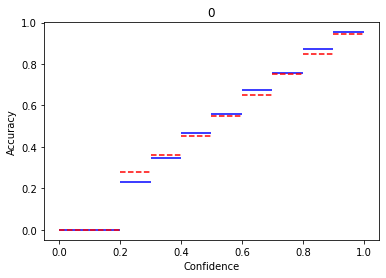

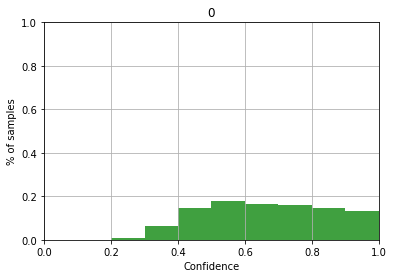

0.014567831039428719
Net number  2


  0%|          | 0/3 [00:00<?, ?it/s]

Training epoch 0:   0%|          | 0/196 [00:00<?, ?it/s]

Val epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

Training epoch 1:   0%|          | 0/196 [00:00<?, ?it/s]

Val epoch 1:   0%|          | 0/40 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/196 [00:00<?, ?it/s]

Val epoch 2:   0%|          | 0/40 [00:00<?, ?it/s]

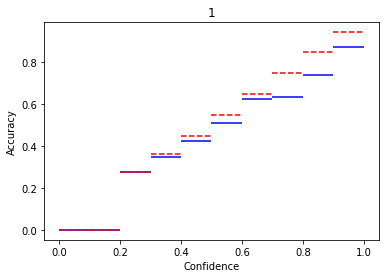

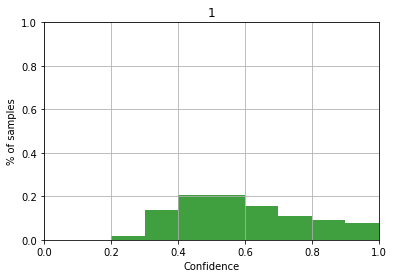

0.0469402156829834
Net number  3


  0%|          | 0/3 [00:00<?, ?it/s]

Training epoch 0:   0%|          | 0/196 [00:00<?, ?it/s]

Val epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

Training epoch 1:   0%|          | 0/196 [00:00<?, ?it/s]

Val epoch 1:   0%|          | 0/40 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/196 [00:00<?, ?it/s]

Val epoch 2:   0%|          | 0/40 [00:00<?, ?it/s]

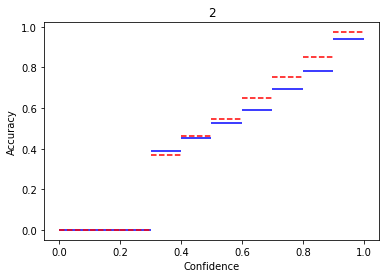

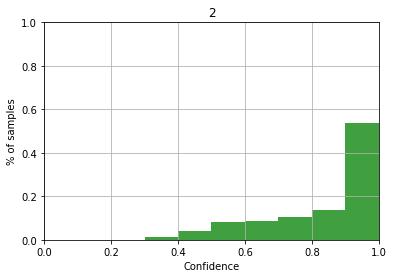

0.04078341293334957


In [96]:
for i, net in enumerate([
            net1, 
            net2, 
            net3
  ]):
  print("Net number ", (i+1))
  train_net(net,number_of_epochs = 3)
  draw_reliability_diagram(net, dl_test_in, str(i))
  draw_scores_histogram(net, dl_test_in, str(i))
  print(ece(net, dl_test_in))


**Question 2** - please summarize your experiments - what influences the good / bad calibration of the network?

**YOUR ANSWER HERE**


## 2 - Out-of-distribution classification

We have seen how the models work with umages of classes the model has learned to recognize. 

But what if we feed to the network images with the objects the model was not trained on?

### Task for you - how does the model behave when processing images with unknown labels?
Please draw the score histograms for the `dl_test_ex` dataset (the test dataset with excluded classes) for those three nets.

**Question 3** - how do differently calibrated nets react to out-of-distribution images? 

**YOUR ANSWER HERE**





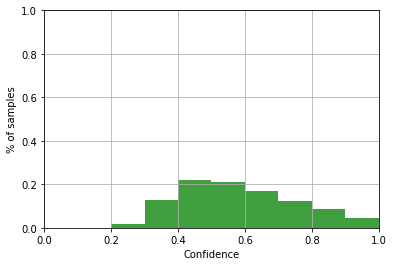

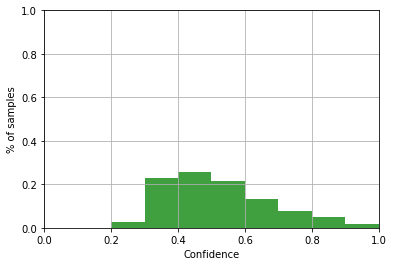

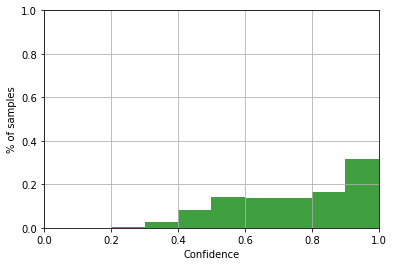

In [97]:
for net in [net1, net2, net3]:
  draw_scores_histogram(net, dl_test_ex)

## 3 - Early exit networks

One of the interesting use cases of model uncertainty are early exit networks, e.g. [Shallow-Deep Networks (SDN)](https://arxiv.org/abs/1810.07052) or [Zero-Time-Waste](https://arxiv.org/abs/2106.05409):

![SDN](https://drive.google.com/uc?id=1REU4cX92utasN3Eix40HMJnhQ2Tmftu6)

The basic idea of SDN is to: 
* pretrain a base network (backbone)
* attach linear probes (internal classifiers) to the internal blocks of the backbone and train them (without modifying the backbone further)
* during inference, if the certainty of an internal classifier is high enough, output the prediction of that IC without further processing.

### Task for you - play with SDN 

Below there is a modified implementation of the above neural net. 

Please:
* add necessary modifications in order to attach a linear layer to each backbone block and to return outputs from those internal classifiers during the forward pass
    * you will need to add modifications to the code of the below network, as well as modify the training loop
* train the basic part of the net (without the internal classifiers)
* train the internal classifiers **(during this part we shouldn't train the rest of the network!)**

For each internal classifier:
* calculate it's accuracy on the validation dataset
* plot the reliability diagram and scores histogram

For the basic net, you may choose one of the previously checked architectures. You don't need to repeat the experiment with different architectures (though you're welcome to!)

In [98]:
class NetWithHeads(nn.Module):
  def __init__(self, hidden_sizes: List[int], downsize_steps: List[int], in_hw: int = 32, n_classes: int = 10):
    """
    Args:
      hidden sizes - hidden size of each consecutive convolution
      downsize_steps - numbers of convolutions for which there will be stride = 2
      in_hw - size of the input image
      n_classes - number of output classes
    """
    super().__init__()

    assert len(hidden_sizes) >= 1

    self.conv1 = nn.Conv2d(3, hidden_sizes[0], 3, padding=1)

    convs = []
    heads = []

    for i, hs in enumerate(hidden_sizes[:-1]):
      hs_next = hidden_sizes[i+1]
      stride = 2 if i+1 in downsize_steps else 1 
      convs.append(
          nn.Sequential(
            nn.ReLU(),
            nn.Conv2d(hs, hs_next, 3, padding=1, stride=stride),
        )
      )
      ##### YOUR CODE HERE ####
      # for each internal convolution, initialize an internal classifier (a single linear layer) 
      # which will take the output from this convolution and perform classification (return N classes)
      ####


    self.convs = nn.Sequential(*convs)

    dhw = in_hw // (2 ** len(downsize_steps))

    out_dim = dhw * dhw * hidden_sizes[-1]
    self.out = nn.Sequential(
        nn.ReLU(),
        nn.Flatten(),
        nn.ReLU(),
        nn.Linear(out_dim, n_classes)
    )

  def forward(self, x):
    x = self.conv1(x)

    ic_outputs = dict()
    for i, c in self.convs:
      x = c(x)
      ##### YOUR CODE HERE ########
      # generate the outputs of each internal classifier and add it to 
      ######
    return self.out(x), ic_outputs

